## Семинар 4: "Сверточные сети"

ФИО: Акишин Кирилл Алексеевич

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import clear_output
%matplotlib inline

### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [2]:
def t_convolve(signal, kernel):
    signal_convolved = np.zeros(len(signal)-len(kernel)+1)
    # 1. не забудьте перевернуть ядро!
    # 2. необходимо реализовать свертку без отступов, т.е. 
    #   размер результирующего сигнала должен быть меньше входного.
    
    for i in range(signal_convolved.shape[0]):
        signal_convolved[i] = np.sum(kernel[::-1] * signal[i:i+len(kernel)])
    
    """
    kernel_h = len(kernel) // 2
    for i in range(kernel_h, signal.shape[0] - kernel_h):
        k = i - kernel_h
        signal_convolved[k] = np.sum(kernel[::-1] * signal[i-kernel_h:i+kernel_h+1])
    """
        
    return signal_convolved

Проверим правильность реализации, сравнив с реализацией из scipy

In [3]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

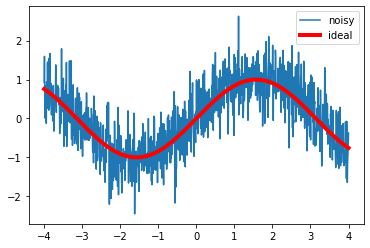

In [4]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку <b>зашумленного</b> сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [7]:
kernel = np.ones(71)
kernel /= kernel.shape[0]

denoised_signal = convolve(noisy_signal, kernel, 'same')

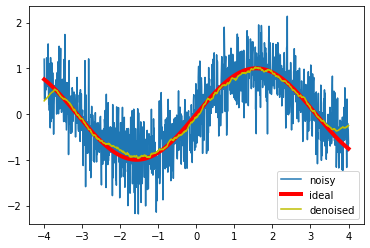

In [8]:
x = np.linspace(-4, 4, 1000)
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x, denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

In [9]:
for size in range(3, 999, 2):
    kernel = np.ones(size)
    kernel /= kernel.shape[0]

    denoised_signal = convolve(noisy_signal, kernel, 'same')    
    error = ((signal - denoised_signal)**2).mean()
    
    print("ks = {}, error = {}".format(size, error))

ks = 3, error = 0.08026676159136617
ks = 5, error = 0.04950844565885279
ks = 7, error = 0.03589107011590721
ks = 9, error = 0.02785135389930866
ks = 11, error = 0.022755916145079446
ks = 13, error = 0.019333442616424577
ks = 15, error = 0.017165722381042664
ks = 17, error = 0.015612161189764932
ks = 19, error = 0.014320739256750292
ks = 21, error = 0.01310923574508421
ks = 23, error = 0.012078843521454302
ks = 25, error = 0.011288553171356743
ks = 27, error = 0.010649222359926443
ks = 29, error = 0.010127759403724892
ks = 31, error = 0.009699204316633167
ks = 33, error = 0.009338146375039704
ks = 35, error = 0.009084779312605826
ks = 37, error = 0.008855462020122799
ks = 39, error = 0.008736691499545634
ks = 41, error = 0.008734574378361042
ks = 43, error = 0.008725069110100016
ks = 45, error = 0.008731281695333975
ks = 47, error = 0.008772361415854114
ks = 49, error = 0.008836098899770127
ks = 51, error = 0.008930225764343944
ks = 53, error = 0.009033092732559134
ks = 55, error = 0.00

#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>

In [10]:
import matplotlib.pyplot as plt
image = plt.imread('ex.jpeg')

In [11]:
image.shape

(640, 640, 3)

<i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [12]:
color_to_bw = np.array([0.2989, 0.5870, 0.1140])

<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

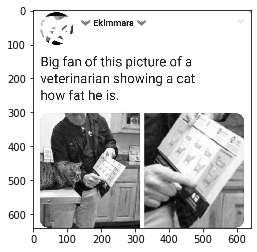

In [13]:
bw_image = convolve(image.flatten(), color_to_bw, 'same')[::3].reshape(*image.shape[:2])
#convolve(noisy_signal, kernel, 'same')
# Не забудьте, что размер bw_image должен быть [w,h], а convolve вам вернет [w,h,1]
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.6 Задайте ядро <a href="https://ru.wikipedia.org/wiki/Оператор_Собеля">фильтра Собеля</a> и продемонстрируйте результат его применения к любому цветному изображению.</i>

In [14]:
from scipy.signal import convolve2d

kernel = np.array([[-1, -2, -1],
                   [0,   0,  0],
                   [+1, +2, +1]])

res_y = convolve2d(bw_image, kernel.T, 'same')
res_x = convolve2d(bw_image, kernel, 'same')

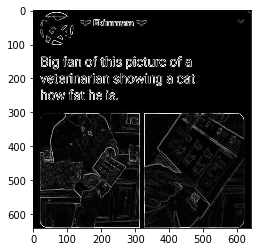

In [15]:
plt.imshow((res_x**2 + res_y**2)**0.5, cmap=plt.cm.Greys_r)

В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [16]:
#[10, 30, 3] -> [10, 30, 4]
#[3, 3, 3, 4]

def t_convolve_bank(signal, kernel):
    assert signal.shape[-1] == kernel.shape[0]
    
    res = []
    for i in range(kernel.shape[-1]):
        r = np.zeros_like(signal[:, :, i])
        for j in range(signal.shape[-1]):
            r += convolve2d(signal[:, :, j], kernel[j, :, :, i], 'same')            
        
        res.append(r)
    
    return np.array(res).transpose((1, 2, 0))

<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

In [17]:
#RGB -> RBG

kernels = np.zeros((3, 1, 1, 3))

kernels[0, 0, 0, 0] = 1
kernels[1, 0, 0, 0] = 1

kernels[2, 0, 0, 1] = 1

kernels[1, 0, 0, 2] = 1
kernels[2, 0, 0, 2] = 1

In [19]:
!wget https://upload.wikimedia.org/wikipedia/ru/1/1b/Simpsons.png

--2021-01-12 07:16:24--  https://upload.wikimedia.org/wikipedia/ru/1/1b/Simpsons.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177017 (173K) [image/png]
Saving to: ‘Simpsons.png’

Simpsons.png        100%[===================>] 172,87K  1,12MB/s    in 0,2s    

2021-01-12 07:16:30 (1,12 MB/s) - ‘Simpsons.png’ saved [177017/177017]



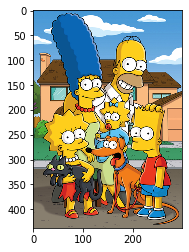

In [20]:
image = plt.imread("Simpsons.png") 
plt.imshow(image)

<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


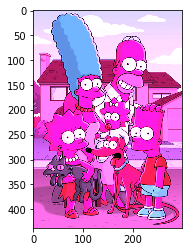

In [22]:
res_image = t_convolve_bank(image.astype(float), kernels)
plt.imshow(res_image)

# Не забудьте, что после свертки вы скорее всего получите тензор типа float. 
# Чтобы imshow нормально отобразил результат, надо привести его к типу uint8 (нпр., при помощи .astype('uint8'))

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [23]:
def maxpool(image, w=2):
    assert(image.ndim == 3)
    
    res = np.zeros((image.shape[0] // w, image.shape[1] // w, image.shape[2]))
    for i in range(0, image.shape[0], w):
        for j in range(0, image.shape[1], w):
            for k in range(image.shape[2]):
                res[i//w, j//w, k] = np.max(image[i:i+w, j:j+w, k])
                
    return res
    

def medianpool(image, w=2):
    assert(image.ndim == 3)
    
    res = np.zeros((image.shape[0] // w, image.shape[1] // w, image.shape[2]))
    for i in range(0, image.shape[0], w):
        for j in range(0, image.shape[1], w):
            for k in range(image.shape[2]):
                res[i//w, j//w, k] = np.median(image[i:i+w, j:j+w, k])
                
    return res

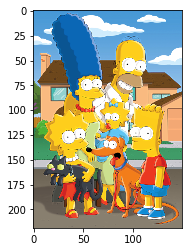

In [25]:
res_image = maxpool(image.astype(float))
plt.imshow(res_image)

Как и в первой части, посмотрим сначала как эта опреация влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


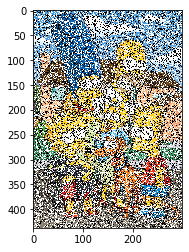

In [26]:
frac = 0.7

res_image = np.array(image)

ind = np.random.rand(*image.shape[:2]) > frac
res_image[ind, :] = 0

ind = np.random.rand(*image.shape[:2]) > frac
res_image[ind, :] = 255

plt.imshow(res_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


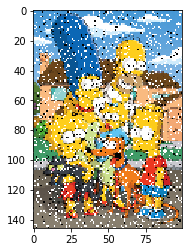

In [29]:
clean_image = medianpool(res_image.astype(float), 3)
plt.imshow(clean_image)

<i>2.3 Какой тип пулинга лучше справился с поставленной задачей? Почему?</i>

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST. Для загрузки данных воспользуйтесь кодом со второго семинара.

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax
1. input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax

Здесь запись "c conv KxK" означает то, что на выходе должно получиться c каналов, а размер ядра — KxK

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

In [8]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [5]:
# пример сверточной сети

image_size = 28
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 3, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*3, 10), nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [6]:
def train(network, epochs, learning_rate):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

Epoch 4... (Train/Test) NLL: 0.266/0.250	Accuracy: 0.924/0.927


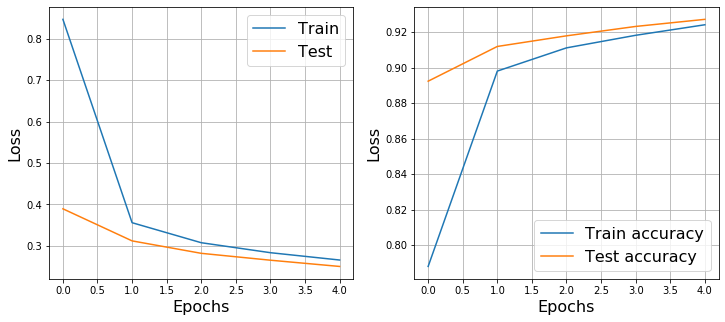

In [9]:
network = ConvClassifier(image_size=28)
train(network, 5, 1e-4)

<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

Epoch 4... (Train/Test) NLL: 0.084/0.071	Accuracy: 0.976/0.979


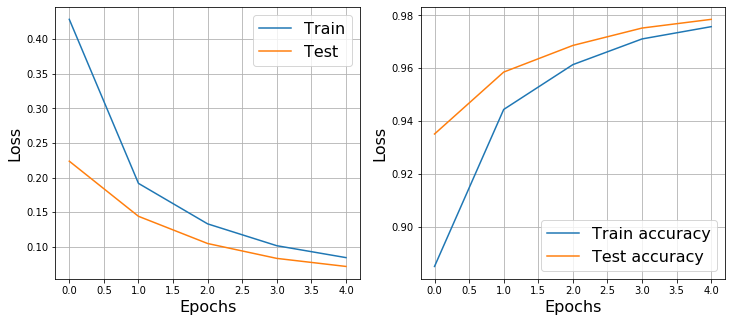

In [10]:
# input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax

image_size = 28
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), 
                                         nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(),
                                         )
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*16, 10), nn.LogSoftmax(dim=1))
        # self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*8*16, 10), nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x


network = ConvClassifier(image_size=28)
train(network, 5, 1e-4)

Epoch 4... (Train/Test) NLL: 0.061/0.056	Accuracy: 0.982/0.981


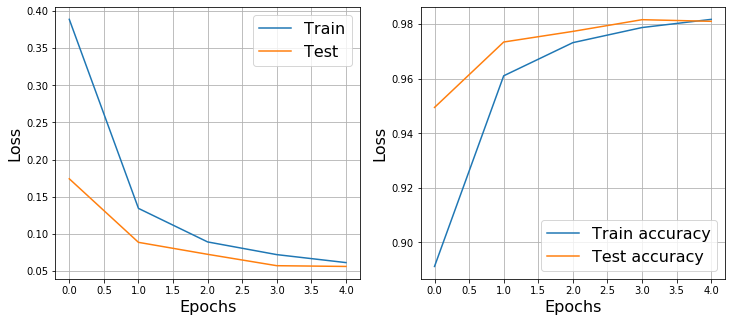

In [11]:
# input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax

image_size = 28
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1), nn.ReLU(), 
                                         nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), 
                                         nn.Conv2d(16, 32, 3, padding=1), 
                                         )
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*32, 10), nn.LogSoftmax(dim=1))
        # self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*8*16, 10), nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x


network = ConvClassifier(image_size=28)
train(network, 5, 1e-4)

<i>3.2 На каких объектах сеть ошибается сильнее всего? Нарисуйте эти объекты с правильными и предсказаными метками.</i>

In [12]:
loss = nn.NLLLoss()

wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    prediction = network(X)
    prediction = network.forward(X).detach().numpy()
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

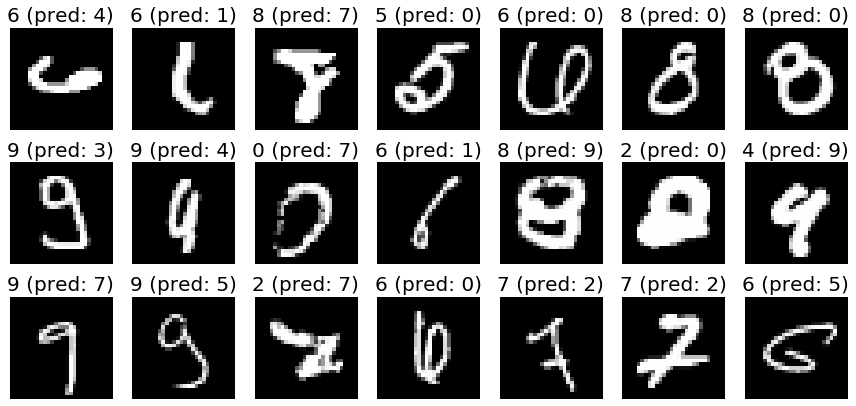

In [13]:
plt.figure(figsize=(15, 7))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{} (pred: {})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

190


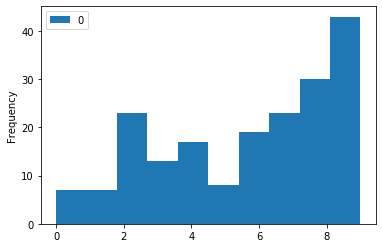

In [14]:
import pandas as pd
print(len(wrong_X))
pd.DataFrame(correct_y).plot.hist(bins=10)

<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

Epoch 4... (Train/Test) NLL: 0.029/0.030	Accuracy: 0.991/0.990


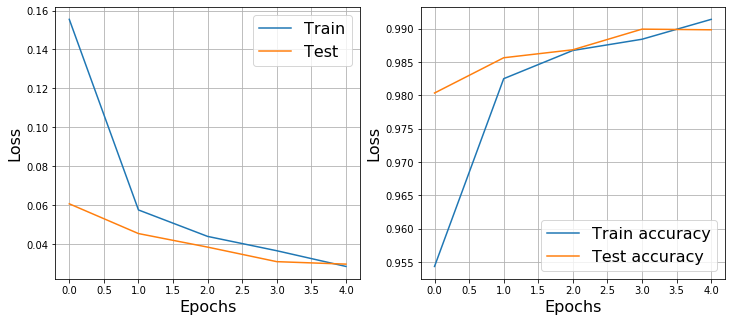

In [15]:
# input -> 32 Conv 5x5 -> ReLU -> 64 Conv 5x5 -> ReLU -> maxpool -> 128 Conv 3x3 -> ravel -> Linear -> LogSoftmax

image_size = 28
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 32, 5, padding=2), nn.ReLU(), 
                                         nn.Conv2d(32, 64, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), 
                                         nn.Conv2d(64, 128, 3, padding=1),
                                         )
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*128, 10), nn.LogSoftmax(dim=1))
        # self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*8*16, 10), nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x


network = ConvClassifier(image_size=28)
train(network, 5, 1e-4)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: